### Task 1  



Q1) C  
Q2) C  
Q3) C  
Q4) B  
Q5) D  
Q6) C  
Q7) C  
Q8) C  
Q9) C  
Q10) D  
Q11) D  
Q12) D  
Q13) C  
Q14) A

### Task 2

#### Install and load the necessary libraries

In [6]:
#All the libraries required 
!pip install numpy 
!pip install pandas 
!pip install matplotlib
!pip install missingno 
!pip install seaborn
!pip install scikit.learn


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [63]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import missingno as msno  
import sklearn as skl

#### Part 1: Data Analysis and preprocessing

In [8]:
#1. load the CSV dataset into a pandas Dataframe 
import pandas as pd 

data = pd.read_csv("ecommerce_data.csv")

In [165]:
#Conduct data analysis
print(f"The names of all the features in the dataset: {data.columns.values}")
print(data.describe())
print(f"The unique values inside Category column: {data['Category'].unique()}\nThe unique values in the action column: {data['Action'].unique()}")


The names of all the features in the dataset: ['CustomerID' 'Timestamp' 'ProductID' 'Category' 'Price' 'Quantity'
 'Action']
        CustomerID    ProductID       Price     Quantity
count  1000.000000  1000.000000  900.000000  1000.000000
mean   1050.128000    10.338000  257.705579     2.975000
std      29.573505     5.771921  144.306057     1.414346
min    1001.000000     1.000000   10.092316     1.000000
25%    1024.000000     5.000000  130.849891     2.000000
50%    1051.000000    10.000000  266.021046     3.000000
75%    1075.000000    15.000000  382.361857     4.000000
max    1100.000000    20.000000  499.859764     5.000000
The unique values inside Category column: ['Clothing' nan 'Books' 'Home' 'Electronics']
The unique values in the action column: ['Add to Cart' 'View' 'Purchase']


<Axes: >

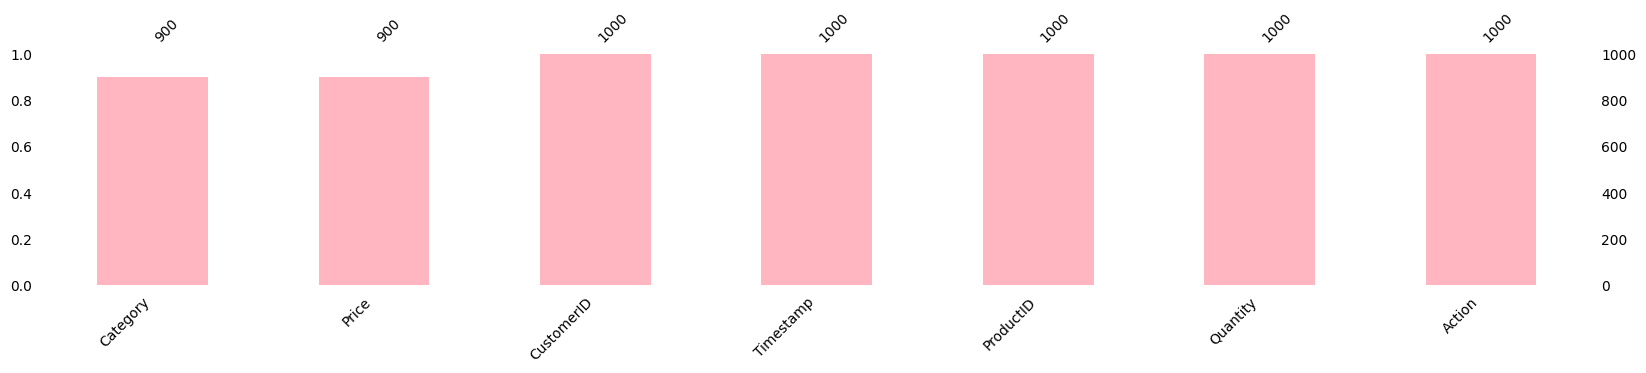

In [77]:
#2. Handle missing values 
#how much is missing and from where 
import missingno as msno 
msno.bar(data, color = "lightpink", sort = "ascending", figsize = (20,3), fontsize=(10))

category and price accounts for only 10% of missingness from each feature. In this case, we can either remove 100 rows of missing values or fill in the missingness with imputation. 

Strategy_1: Get rid of 100 rows of data reducing the total dataset to 900 samples

In [13]:
import copy 
data_undersample = copy.deepcopy(data)
data_undersample.dropna(axis = 0, inplace = True) 

Strategy_2: Replace the missing values with the mode or the mean but before that we check the quantity of the ratio of the products in each category.

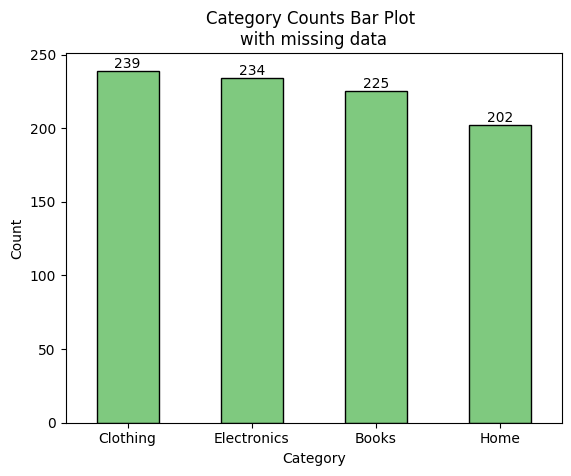

Clothing has the highest modal value in the category feature 
Ratio of the quantity of the products in each category {'Clothing': 26.56, 'Books': 25.0, 'Home': 22.44, 'Electronics': 26.0}


In [108]:
import matplotlib.pyplot as plt 
category_counts = data['Category'].value_counts()

quantity_ratio_category = {
    "Clothing": round((category_counts["Clothing"] / category_counts.sum()) * 100, 2),
    "Books": round((category_counts["Books"] / category_counts.sum()) * 100, 2),
    "Home": round((category_counts["Home"] / category_counts.sum()) * 100, 2),
    "Electronics": round((category_counts["Electronics"] / category_counts.sum()) * 100, 2)
}

ax = category_counts.plot(kind='bar', colormap='Accent', edgecolor = "black")

plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category Counts Bar Plot \nwith missing data')
plt.xticks(rotation = 0)

for index, value in enumerate(category_counts):
    ax.text(index, value, str(value), ha='center', va='bottom')
plt.show()
print(f"Clothing has the highest modal value in the category feature \nRatio of the quantity of the products in each category {quantity_ratio_category}")

Since the missing values we are trying to replace are categorical. This cannot be replace by the mean or median, so the logical option would be mode. However we do not want to cause the dataset to be imbalanced, so we will impute the missing data according the ranked modal values to maintain the ratio at which the items in category is distributed. Consequenty the prices will be imputed according to mean of the items in category feature. 

In [88]:
#3. Analyze customer interactions by creating a crosstab of action and category feature.
cross_tab = pd.crosstab(data['Category'], data['Action'])
print(f"A table to demonstrate the total number of actions for each item in category feature \nfrom {data['Timestamp'].min()} to {data['Timestamp'].max()}" )
cross_tab

A table to demonstrate the total number of actions for each item in category feature 
from 2023-01-01 to 2025-09-26


Action,Add to Cart,Purchase,View
Category,,,
Books,75,76,74
Clothing,94,66,79
Electronics,0,234,0
Home,71,60,71


Now we know if an action is purchase there is greater likelihood of the category being electronics, the most viewed and added to cart items are clothing. Books and home category have random actions  

In [91]:
#filter the data according to action and where category value is missing. Find the number of samples with missing category grouped according to action. 
action_counts ={}
actions = data['Action']
for action in actions:
    filtered_data = data[(data['Action'] == action) & (data['Category'].isna())]
    count = len(filtered_data)
    action_counts[action] = count 
print(f"The number missing category value for each action{action_counts}")

The number missing category value for each action{'Add to Cart': 31, 'View': 39, 'Purchase': 30}


30 samples from the dataset with missing category that belong to the action of purchase will be filled with electronics, since the action of purchase was most conducted on electronics category(234) as seen from the above table. 31 rows(Action:Add to cart) will be filled with clothing. View has the most Null values, this could be imputed with books and home at random. This gives a balanced dataset as opposed to filling all missing values with the modal value of Electronics 


In [19]:
import numpy as np 
np.random.seed(42)
data_oversample= copy.deepcopy(data)
data_oversample['Category'] = np.where((data['Action'] == 'Purchase') & (data['Category'].isna()), 'Electronics', data['Category'])
data_oversample['Category'] = np.where((data['Action'] == 'Add to Cart') & (data['Category'].isna()), 'Clothing', data['Category'])
data_oversample['Category'] = np.where(data_oversample['Category'].isna(), np.random.choice(np.array (['Books', 'Home']), len(data_oversample['Category'].isna())), data_oversample['Category'])


The prices will be filled according to the average mean values of the category of the product

In [20]:
mean_prices = data_oversample.groupby('Category')['Price'].aggregate('mean')
print(mean_prices)

Category
Books          263.292355
Clothing       246.535105
Electronics    261.835832
Home           259.914688
Name: Price, dtype: float64


In [21]:
data_oversample['Price'] = np.where((data_oversample['Price'].isna()) & (data_oversample['Category'] == 'Books'),mean_prices[0], data_oversample['Price'])
data_oversample['Price'] = np.where((data_oversample['Price'].isna()) & (data_oversample['Category'] == 'Clothing'),mean_prices[1], data_oversample['Price'])
data_oversample['Price'] = np.where((data_oversample['Price'].isna()) & (data_oversample['Category'] == 'Electronics'),mean_prices[2], data_oversample['Price'])
data_oversample['Price'] = np.where((data_oversample['Price'].isna()) & (data_oversample['Category'] == 'Home'),mean_prices[3], data_oversample['Price'])


/tmp/ipykernel_6945/3253736681.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_oversample['Price'] = np.where((data_oversample['Price'].isna()) & (data_oversample['Category'] == 'Books'),mean_prices[0], data_oversample['Price'])
/tmp/ipykernel_6945/3253736681.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_oversample['Price'] = np.where((data_oversample['Price'].isna()) & (data_oversample['Category'] == 'Clothing'),mean_prices[1], data_oversample['Price'])
/tmp/ipykernel_6945/3253736681.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer key

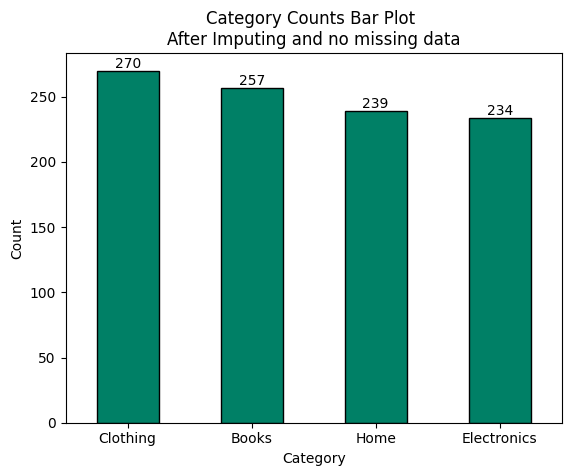

Ratio of the quantity of the products in each category {'Clothing': 27.0, 'Books': 25.7, 'Home': 23.9, 'Electronics': 23.4}


In [109]:
category_counts = data_oversample['Category'].value_counts()
ax = category_counts.plot(kind='bar', colormap='summer', edgecolor = "black")

plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category Counts Bar Plot \nAfter Imputing and no missing data')
plt.xticks(rotation = 0)

for index, value in enumerate(category_counts):
    ax.text(index, value, str(value), ha='center', va='bottom')
plt.show()

category_counts_new = data_oversample['Category'].value_counts()
quantity_ratio_category_new = {
    "Clothing": round((category_counts_new["Clothing"] / category_counts_new.sum()) * 100, 2),
    "Books": round((category_counts_new["Books"] / category_counts_new.sum()) * 100, 2),
    "Home": round((category_counts_new["Home"] / category_counts_new.sum()) * 100, 2),
    "Electronics": round((category_counts_new["Electronics"] / category_counts_new.sum()) * 100, 2) 
}


print(f"Ratio of the quantity of the products in each category {quantity_ratio_category_new}")

The ratio of each of the category has been maintained more or less. The new data set we have are data_oversample and data_undersample. We will continue work with the dataset called data_oversample, this is a personal preference. Because more data which has been imputed is better than less

#### Part 2: Feature Engineering and Analysis

In [57]:
#1. creating a new feature called TotalSpent 
data_oversample['TotalSpent'] = data_oversample['Price'] * data_oversample['Quantity']

In [120]:
Customer_spent = data_oversample.groupby(['CustomerID', 'Action'])['TotalSpent'].aggregate('sum')
Customer_spent = Customer_spent.reset_index()
Customer_spent.sort_values(by=['TotalSpent'], ascending=False)


,CustomerID,Action,TotalSpent
257,1092,Purchase,12070.523164
177,1062,Purchase,9438.754884
112,1039,Purchase,9133.567806
253,1090,View,8745.676569
94,1033,Add to Cart,8454.540083
...,...,...,...
111,1039,Add to Cart,159.257526
115,1040,Purchase,137.842282
86,1029,View,125.435622
141,1050,Add to Cart,73.665663


Customer 1092 spent the highest amount purchasing  

In [136]:
#2. Group the data by category and analyze the most popular categories. 

popular_categories = data_oversample.groupby(['Category', 'Action'])['Quantity'].sum()   
pop_categ = popular_categories.reset_index().sort_values(by=['Quantity'], ascending=False)

#calculate the conversion rate of how many items added to cart gets converted into a purchase 
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)

    conversion_rate = {
        "Books": round((popular_categories[1]/(popular_categories[0]+popular_categories[1])*100),2),
        "Clothing":round((popular_categories[4]/(popular_categories[3]+popular_categories[4])*100),2),
        "Electronics": round((popular_categories[6]/(popular_categories[6])*100),2),
        "Home": round((popular_categories[8]/(popular_categories[7]+popular_categories[8])*100),2),
    }



print(f"The conversion rate for items in each category {conversion_rate} \nwhich implies 57% of the books added to cart end up being purchased whilst only 33% of the clothes added to cart are purchased")
pop_categ


The conversion rate for items in each category {'Books': 57.0, 'Clothing': 33.81, 'Electronics': 100.0, 'Home': 51.17} 
which implies 57% of the books added to cart end up being purchased whilst only 33% of the clothes added to cart are purchased


,Category,Action,Quantity
6,Electronics,Purchase,695
3,Clothing,Add to Cart,372
9,Home,View,294
1,Books,Purchase,289
2,Books,View,247
5,Clothing,View,244
0,Books,Add to Cart,218
8,Home,Purchase,218
7,Home,Add to Cart,208
4,Clothing,Purchase,190


The most popular items are electronics, because it has the highest conversion rate, the item with the second most highest conversion rate is Book. Customers have the most reluctance to make a purchase decision for Clothing.

In [139]:
#3 The average prices for products in each category 
mean_prices.sort_values(ascending=False)

Category
Books          263.292355
Electronics    261.835832
Home           259.914688
Clothing       246.535105
Name: Price, dtype: float64

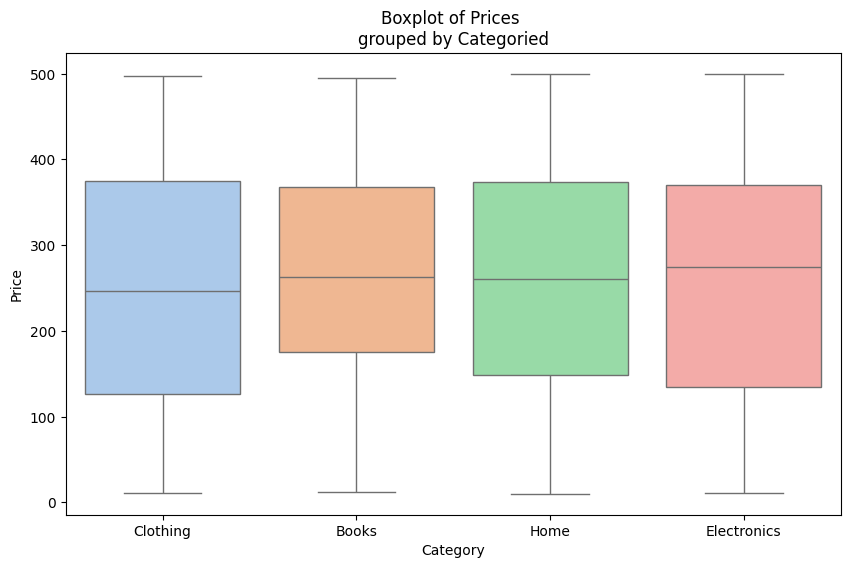

In [41]:
import seaborn as sns
# sns.set_palette('rainbow')
plt.figure(figsize= (10,6))
sns.boxplot(x = 'Category', y='Price', data = data_oversample, palette='pastel', hue='Category', legend=False)
plt.ylabel('Price')
plt.title('Boxplot of Prices \ngrouped by Categoried')
plt.xticks(rotation = 0)
plt.show()

It seems that the products in the Books and electronics category is the most expensive but clothing has as extensive price range. 

#### Part 3 Machine Learning Preprocessing 

In [60]:
#1. encoded dataset 
data_oversample_encoded = pd.get_dummies(data_oversample, columns = ['Category', 'Action'], drop_first=True)
data_oversample_encoded.head(5)

,CustomerID,Timestamp,ProductID,Price,Quantity,TotalSpent,Category_Clothing,Category_Electronics,Category_Home,Action_Purchase,Action_View
0,1052,2023-01-01,2,125.570224,2,251.140447,True,False,False,False,False
1,1093,2023-01-02,15,191.996781,3,575.990343,True,False,False,False,False
2,1015,2023-01-03,8,40.645691,1,40.645691,True,False,False,False,False
3,1072,2023-01-04,8,263.292355,2,526.584710,False,False,False,False,True
4,1061,2023-01-05,17,263.292355,5,1316.461775,False,False,False,True,False


Since the first column of each categorical variable was dropped whilst encoding to control for multicolleneariy. The reference column for Category is Category_Books. And the reference column for Action is Action_add_to_cart 

In [140]:
#2. Standardized numerical features
from sklearn.preprocessing import StandardScaler
data_processed = copy.deepcopy(data_oversample_encoded)

features = ['Price', 'Quantity', 'TotalSpent']
scaler = StandardScaler()
data_processed[features] = scaler.fit_transform(data_processed[features])

print(f"Z-score standardized data")
data_processed.head(5)


Z-score standardized data


,CustomerID,Timestamp,ProductID,Price,Quantity,TotalSpent,Category_Clothing,Category_Electronics,Category_Home,Action_Purchase,Action_View
0,1052,2023-01-01,2,-0.964971,-0.689709,-0.886785,True,False,False,False,False
1,1093,2023-01-02,15,-0.479549,0.017685,-0.339854,True,False,False,False,False
2,1015,2023-01-03,8,-1.585569,-1.397104,-1.241183,True,False,False,False,False
3,1072,2023-01-04,8,0.041453,-0.689709,-0.423036,False,False,False,False,True
4,1061,2023-01-05,17,0.041453,1.432473,0.906835,False,False,False,True,False


In [169]:
data_processed['Quantity'].min()

-1.3971035815086115

In [72]:
#3. Split the dataset into training and testing sets 
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data_processed, test_size=0.2, random_state=42)

#### Part 4 Insights and Data Preparation 

1. Write a summary of your data analysis, feature engineering, and preprocessing steps.

Data analysis: In the data analysis section the intital data analysis is conducted to observe the data types in the columns of the dataset. print(data.columns.values) provides us the name of all the features in the dataset and print(data.describe()) gives us the statistical description of the numeric data, leaving out the categorical data. We also observe the unique names of the values in the categorical columns. This provides us with the information of missing data in the category column. We proceed to check for overall missingness in the data. And take 2 probable strategies to overcome this problem. The first strategy is to either remove the missing rows from the entire dataset. This would account to a 10% reduction in the samples. However, the more probable strategy was to impute for the missing data, this would make sure we did not lose valuable information. The imputation of the data was conducted by taking the modal value of the category feature. This returned the value of Clothing. However, replacing all the missing values with the category value of clothing would account for an imbalanced dataset. In order to return a balanced dataset the missing values were filled with ranked modal values. This information was extracted from observing customer interaction with the items in the category feature and the majority action which is taken for each of the products. The missing price values were then filled according to the mean values grouped by the items in each category. 

Feature engineering and analysis: In the feature engineering section we added an extra column to the dataset called TotalSpent which was the product of the Price and the quantity columns. Representing the total amount of money registered for the actions of purchase, adding to cart and viewing. Even though the variable is called TotalSpent, the money was not spent by the customer until the products were purchased. 
By grouping the TotalSpent feature according to actions we observe that CustomerID 1092 spent the most on the ecommerce purchasing items worth of 12,070 over a span of 2 years. 
We then analysed the most popular item in the category feature based on the different types of actions that were taken and the number of times these actions were taken. Electronics were the most popular item with the highest conversion rate of 100% followed by Books at 57% and then household items at 51%, the least popular item was clothing because only 33 article of clothing out of every 100 is purchased. 
We also observed the average prices for each of the items. Book and electronics were the most expensive relative to the other items and clothing had the most extensive price range starting from 100 to almost 400 BDT.

Machine learning and preprocessing: In the preprocessing stage we encoded the categorical variables using one-hot encoding. This enables future ML models to conduct analysis on the dataset without biased outputs. The Price and the Quantity variables were scaled to represent values ranging from -2 to 2, this will be useful for running regression on the dataset to capture the relation between the variables without skewing the output. However, we need to be cautious when interpreting the output because a negative coefficient in price and Quantity does not hold any meaning in real world sense. The dataset was then split into 80:20 ratio for testing and training. 

In [229]:
data_oversample['Timestamp'] = pd.to_datetime(data_oversample['Timestamp'])

In [255]:
data_oversample_2023 =  data_oversample[(data_oversample['Timestamp'].dt.year == 2023) & (data_oversample['Action'] == 'Purchase')]
data_oversample_2024 = data_oversample[(data_oversample['Timestamp'].dt.year == 2024) & (data_oversample['Action'] == 'Purchase')]
data_oversample_2025 = data_oversample[(data_oversample['Timestamp'].dt.year == 2025) & (data_oversample['Action'] == 'Purchase')]

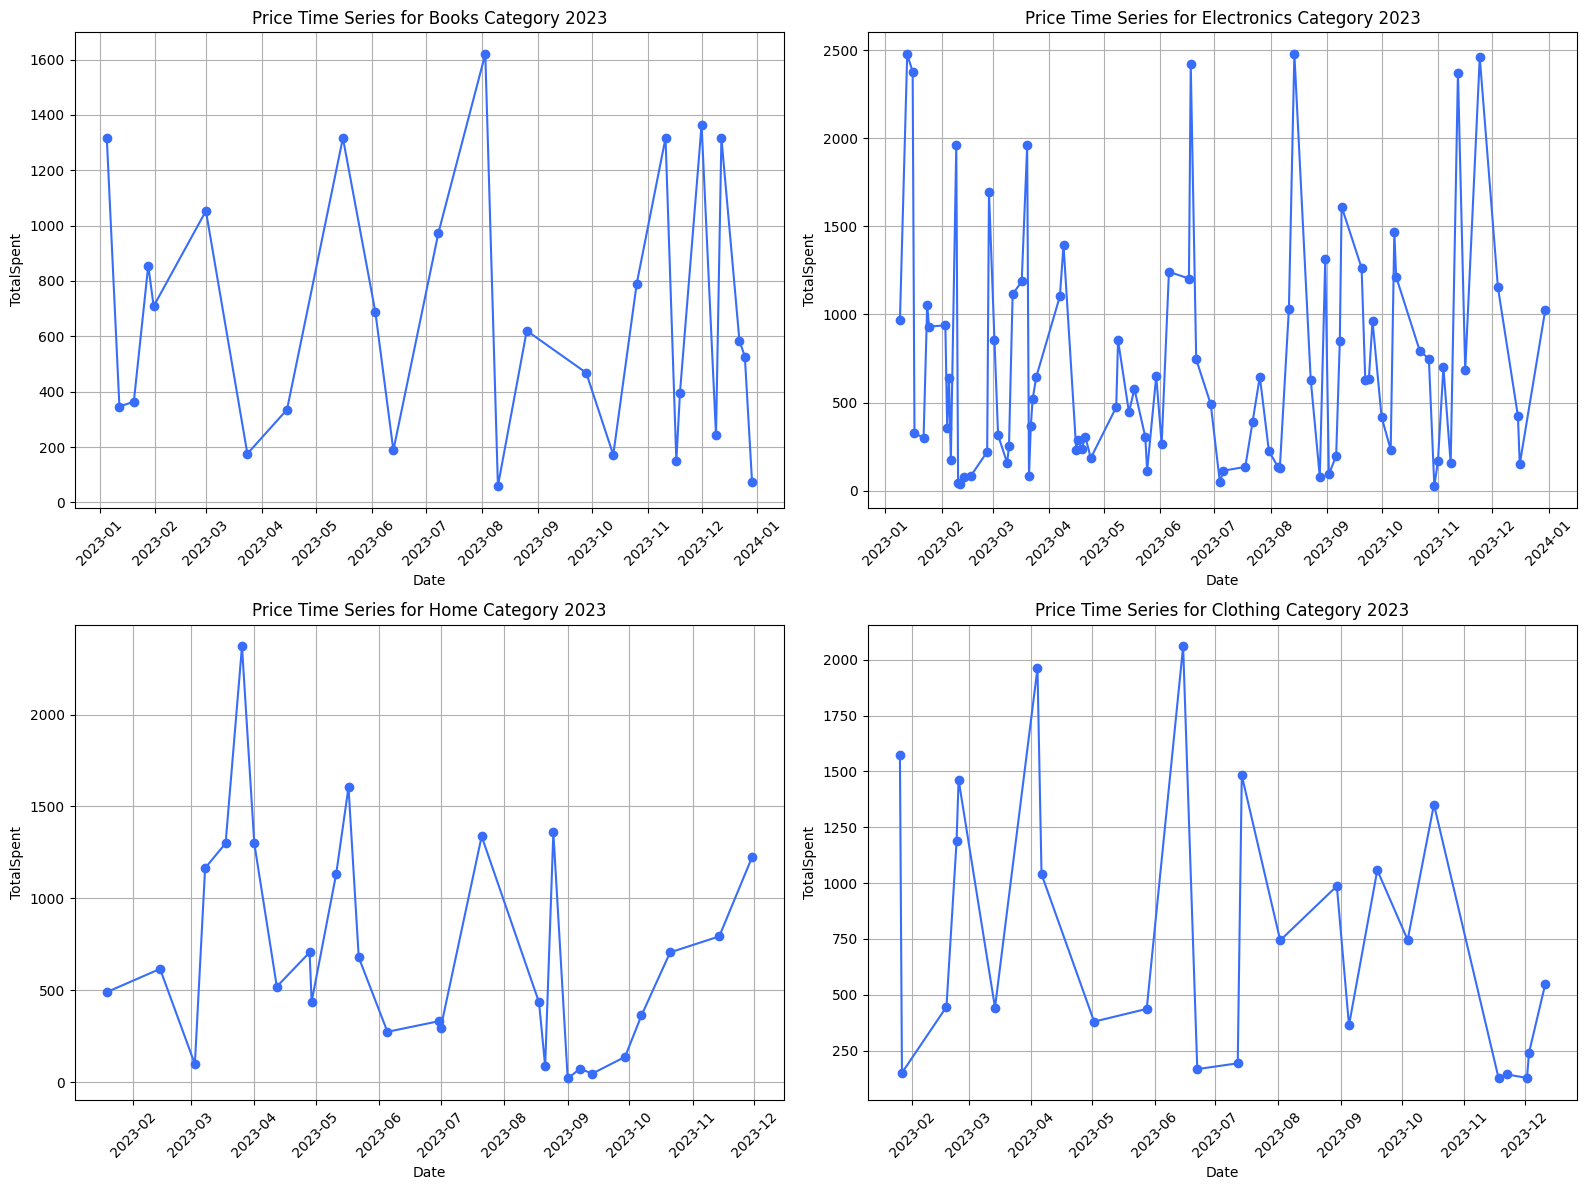

In [258]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter

# Get unique categories
categories = data_oversample_2023['Category'].unique()

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.ravel()

# Iterate over categories and create time series plots
for i, category in enumerate(categories):
    category_data = data_oversample_2023[data_oversample_2023['Category'] == category]

    axs[i].plot(category_data['Timestamp'], category_data['TotalSpent'], marker='o', linestyle='-')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('TotalSpent')
    axs[i].set_title(f'Purchase Time Series for {category} Category 2023')
    axs[i].grid(True)

    # Format the x-axis to display only the year and month
    axs[i].xaxis.set_major_locator(MonthLocator(interval=1))
    axs[i].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()

plt.show()

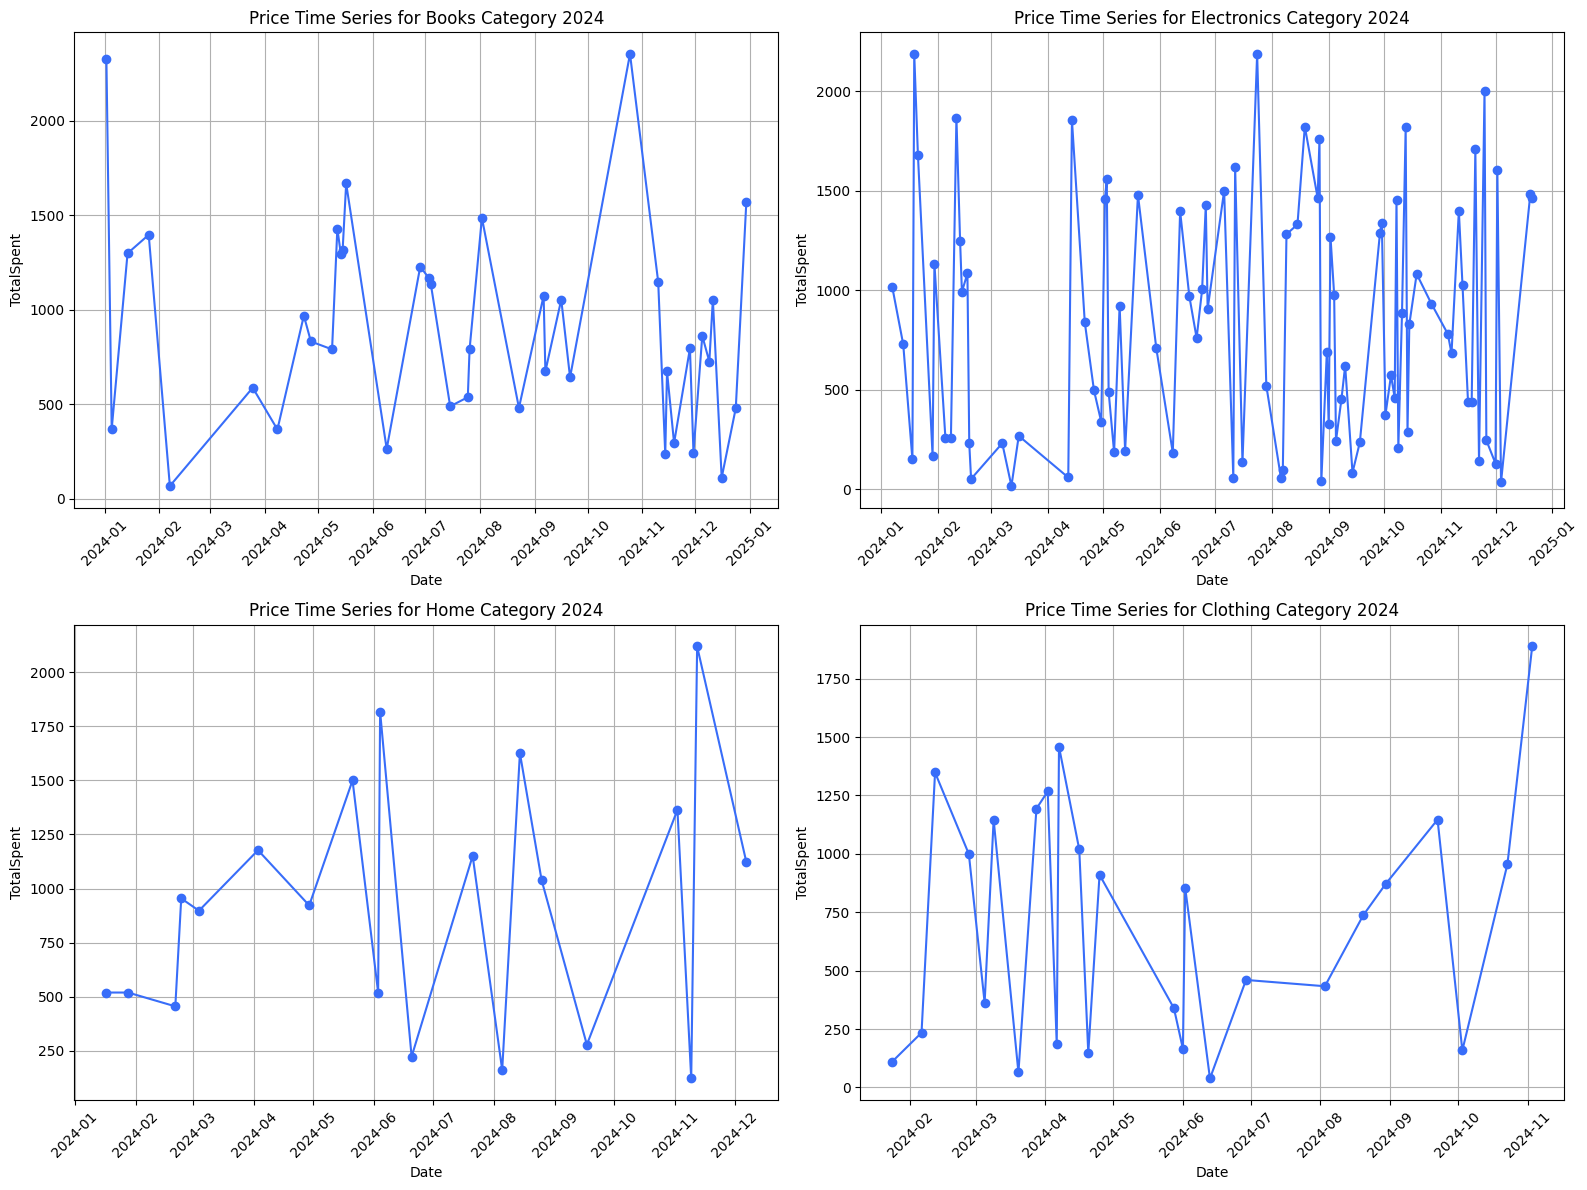

In [259]:
# Get unique categories
categories = data_oversample_2024['Category'].unique()

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.ravel()

# Iterate over categories and create time series plots
for i, category in enumerate(categories):
    category_data = data_oversample_2024[data_oversample_2024['Category'] == category]

    axs[i].plot(category_data['Timestamp'], category_data['TotalSpent'], marker='o', linestyle='-')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('TotalSpent')
    axs[i].set_title(f'Purchase Time Series for {category} Category 2024')
    axs[i].grid(True)

    # Format the x-axis to display only the year and month
    axs[i].xaxis.set_major_locator(MonthLocator(interval=1))
    axs[i].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()

plt.show()

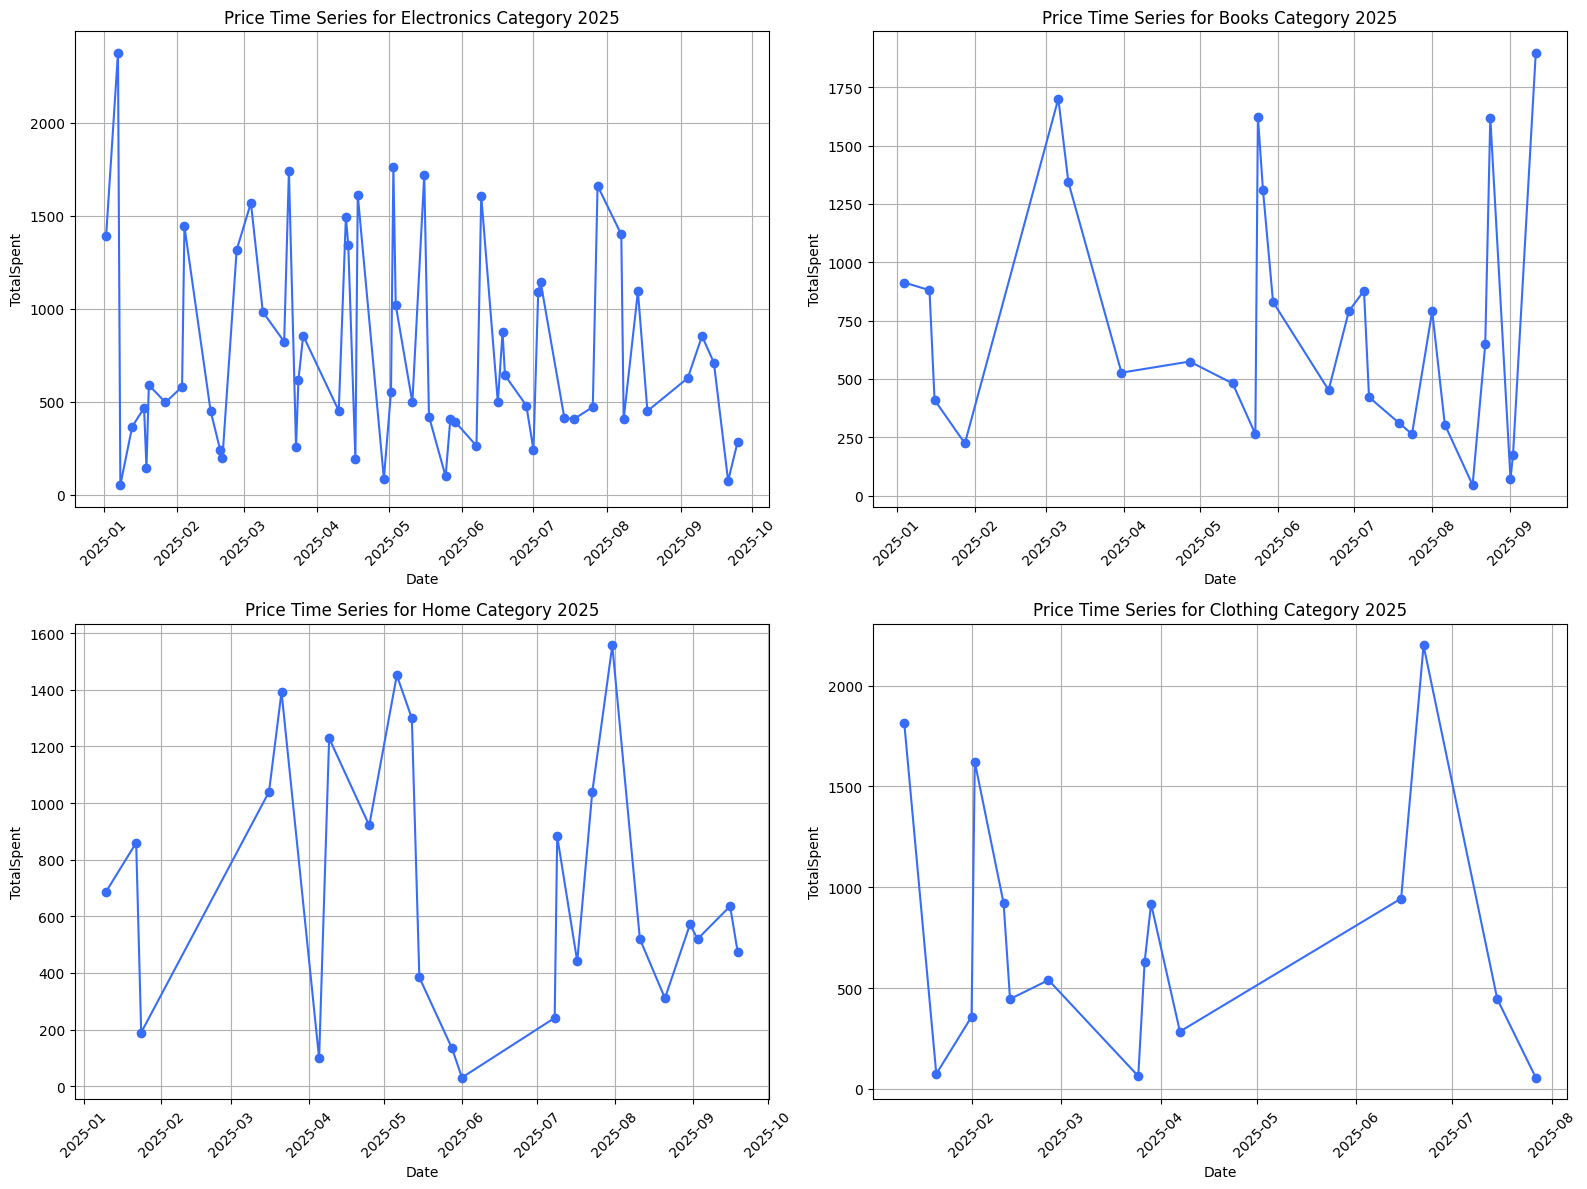

In [260]:
# Get unique categories
categories = data_oversample_2025['Category'].unique()

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.ravel()

# Iterate over categories and create time series plots
for i, category in enumerate(categories):
    category_data = data_oversample_2025[data_oversample_2025['Category'] == category]

    axs[i].plot(category_data['Timestamp'], category_data['TotalSpent'], marker='o', linestyle='-')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('TotalSpent')
    axs[i].set_title(f'Purchase Time Series for {category} Category 2025')
    axs[i].grid(True)

    # Format the x-axis to display only the year and month
    axs[i].xaxis.set_major_locator(MonthLocator(interval=1))
    axs[i].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()

plt.show()

In [282]:
dt_23=data_oversample_2023.groupby('Category')['Quantity'].aggregate('sum')
dt_24=data_oversample_2024.groupby('Category')['Quantity'].aggregate('sum')
dt_25=data_oversample_2025.groupby('Category')['Quantity'].aggregate('sum')
dt_23 = dt_23.rename('Year 2023')
dt_24 = dt_24.rename('Year 2024')
dt_25 = dt_25.rename('Year 2025')
result = pd.concat([dt_23,dt_24,dt_25], axis=1)
result

,Year 2023,Year 2024,Year 2025
Category,,,
Books,80,135,74
Clothing,70,76,44
Electronics,240,279,176
Home,83,63,72


2.There are no noticeable rise in price of the items throughout the years. However, the year of 2024 experienced the most purchase in all categories except Home products. There is a 68% increase in the purchase of books from 2023 to 2024. Since the year of 2025 has data only until October we cannot compare the values with the previous year 

3.The feature-engineering and preprocessing tehniques used for imputing the missing data was to use statistical values of mode for the categorical variable and mean for the price varibale. The rational behind this is that a categorical variable can be averaged however, even in the selecting the modal value is the possibilty of imbalancing the data by increasing the count of only the most occuring item. To counter this problem interaction of the customers were also taken into account to impute the missing values in a manner that would maintain the old distribution of the items in the category feature. 

The other technique implemented was the one-hot encoding to encode the categorical and the action feature. The rational behind this technique is to ensure that we do not assign weight to any particular item in the categorical feature or this will bias the output when we run a regression model on the dataset. One-hot encoding ensures that the relation bewteen the dependent and independent variables are capture without placing any importance on the numeric coefficient that is returned from a regression model.  
  